<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/process/dynamicsimul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/equinor/neqsimpython.git

  Cloning https://github.com/equinor/neqsimpython.git to /tmp/pip-req-build-1jvcnhqa
  Running command git clone --filter=blob:none --quiet https://github.com/equinor/neqsimpython.git /tmp/pip-req-build-1jvcnhqa
  Resolved https://github.com/equinor/neqsimpython.git to commit f058c02263da0f0905d50f77eb7fd832b2cf081f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 4.7 MB/s eta 0:00:00
  Created wheel for neqsim: filename=neqsim-2.5.12-py3-none-any.whl size=28201126 sha256=e831463070e53e8406b8bbbaf2c783368956d83aa7c41e0b39ea21f62bbfce9f
  Stored in directory: /tmp/pip-ephem-wheel-cache-3un61wag/wheels/68/ff/ac/70b246ceb8f74c0d2b14d9dd5b7c6f735610bc7e341ec8f5de
Successfully built neqsim


#Dynamic process calculations using NeqSim

In the following examples we will give examples of how neqsim can be used for dynamic process simulations.

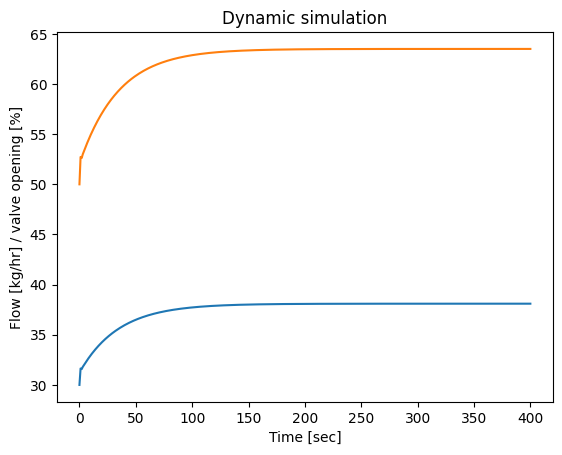

In [17]:
import neqsim
from neqsim import jNeqSim

import matplotlib.pyplot as plt

fluid1 = jNeqSim.thermo.system.SystemSrkEos((273.15 + 25.0), 10.00)
fluid1.addComponent("methane", 0.900)
fluid1.addComponent("ethane", 0.100)
fluid1.addComponent("n-heptane", 1.00)
fluid1.setMixingRule('classic')

stream1 = jNeqSim.processSimulation.processEquipment.stream.Stream("Stream1", fluid1)
stream1.setFlowRate(50.0, "kg/hr")
stream1.setPressure(10.0, "bara")

valve1 =  jNeqSim.processSimulation.processEquipment.valve.ThrottlingValve("valve_1", stream1)
valve1.setOutletPressure(5.0)
initialvalveopening = 30
valve1.setPercentValveOpening(initialvalveopening)

separator1 =  jNeqSim.processSimulation.processEquipment.separator.Separator("sep 1")
separator1.addStream(valve1.getOutletStream())

valve2 = jNeqSim.processSimulation.processEquipment.valve.ThrottlingValve("valve_2", separator1.getLiquidOutStream())
valve2.setOutletPressure(1.0)
valve2.setPercentValveOpening(50)

valve3 = jNeqSim.processSimulation.processEquipment.valve.ThrottlingValve("valve_3", separator1.getGasOutStream())
valve3.setOutletPressure(1.0)
valve3.setPercentValveOpening(50)

flowTransmitter = jNeqSim.processSimulation.measurementDevice.VolumeFlowTransmitter(stream1)
flowTransmitter.setUnit("kg/hr")
flowTransmitter.setMaximumValue(100.0)
flowTransmitter.setMinimumValue(1.0)

flowController = jNeqSim.processSimulation.controllerDevice.ControllerDeviceBaseClass()
flowController.setTransmitter(flowTransmitter)
flowController.setReverseActing(True)
flowController.setControllerSetPoint(63.5)
#Settin Kp, Ti, Td of PID regulator
flowController.setControllerParameters(0.1, 5.0, 0.0)

p = jNeqSim.processSimulation.processSystem.ProcessSystem()
p.add(stream1)
p.add(valve1)
p.add(separator1)
p.add(valve2)
p.add(valve3)
p.add(flowTransmitter)
valve1.setController(flowController)
valve1.setCalculateSteadyState(False)

p.run();

time = []
valveopening = []
flow = []

p.setTimeStep(1);
for i in range(401):
  time.append(p.getTime())
  valveopening.append(valve1.getPercentValveOpening())
  flow.append(flowTransmitter.getMeasuredValue())
  #print("volume flow ", flowTransmitter.getMeasuredValue(), " valve opening ", valve1.getPercentValveOpening(), " pressure ", separator1.getGasOutStream().getPressure())
  p.runTransient()

plt.plot(time, valveopening)
plt.plot(time, flow)
plt.title("Dynamic simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Flow [kg/hr] / valve opening [%]")
plt.show()

#Controlling pressure and liquid level in separator
In this example we establish a process where a liquid and gas are produced to a separator, and we try to control pressure and liquid level in the separator. We will add a PID regluator to the liquid controll valve and a PD regulator to the valve regulating the pressure in the separator. We will add some perturbations to see how the process reacts.

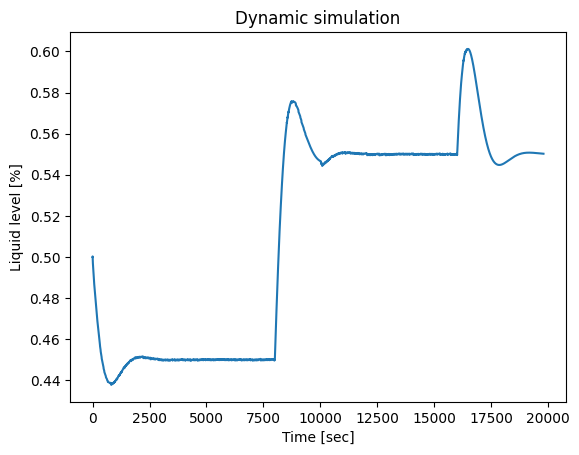

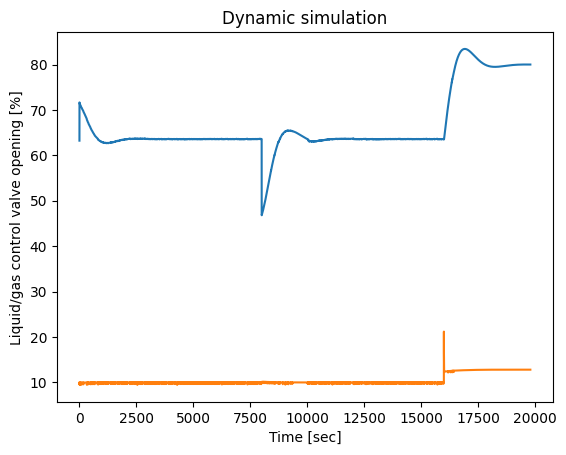

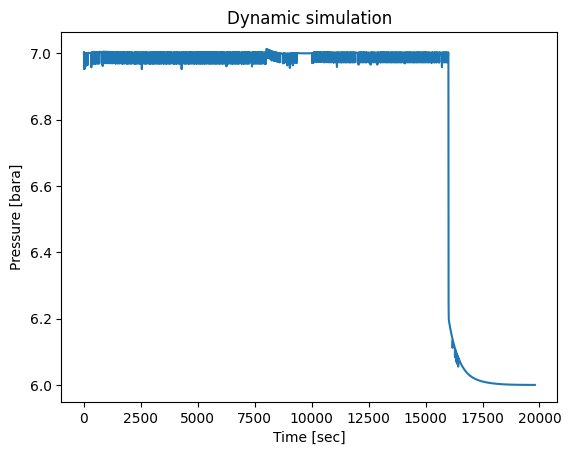

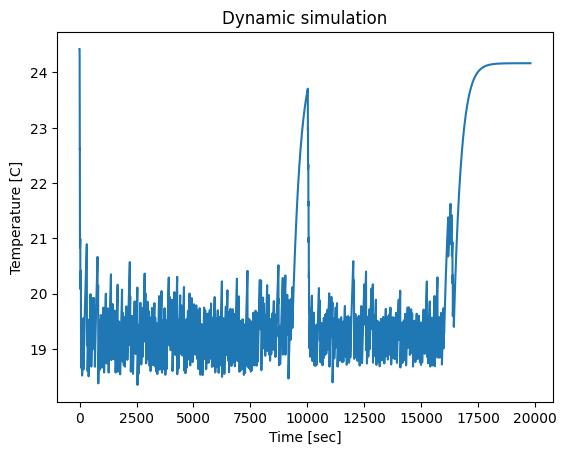

In [36]:
import neqsim
from neqsim import jNeqSim

import matplotlib.pyplot as plt

fluid1 = jNeqSim.thermo.system.SystemSrkEos((273.15 + 25.0), 10.00)
fluid1.addComponent("methane", 0.900)
fluid1.addComponent("n-heptane", 1.00)
fluid1.setMixingRule('classic')

fluid2 = jNeqSim.thermo.system.SystemSrkEos((273.15 + 25.0), 10.00);
fluid2.addComponent("methane", 1.1)
fluid2.addComponent("n-heptane", 1.001)
fluid2.setMixingRule(2)

stream1 = jNeqSim.processSimulation.processEquipment.stream.Stream("Stream1", fluid1);
stream1.setCalculateSteadyState(True);
stream1.setFlowRate(100.0, 'kg/hr')

valve1 = jNeqSim.processSimulation.processEquipment.valve.ThrottlingValve("valve_1", stream1);
valve1.setOutletPressure(7.0);
valve1.setPercentValveOpening(50);
valve1.setCalculateSteadyState(False)

purgeStream = jNeqSim.processSimulation.processEquipment.stream.Stream("Purge Stream", fluid2);
purgeStream.setFlowRate(1.0, 'kg/hr')

purgeValve = jNeqSim.processSimulation.processEquipment.valve.ThrottlingValve("purgeValve", purgeStream);
purgeValve.setOutletPressure(7.0);
purgeValve.setPercentValveOpening(50.0);
purgeValve.setCalculateSteadyState(False)

separator1 = jNeqSim.processSimulation.processEquipment.separator.Separator("separator_1");
separator1.addStream(valve1.getOutletStream())
separator1.addStream(purgeValve.getOutletStream())
separator1.setCalculateSteadyState(False)
separator1.setSeparatorLength(1.0)
separator1.setInternalDiameter(0.2)
separator1.setLiquidLevel(0.5)

valve2 = jNeqSim.processSimulation.processEquipment.valve.ThrottlingValve("valve_2", separator1.getLiquidOutStream());
valve2.setOutletPressure(1.0)
valve2.setPercentValveOpening(40)
valve2.setCalculateSteadyState(False)
valve2.setMinimumValveOpening(1.0)
valve2.setCv(3.9)

valve3 =  jNeqSim.processSimulation.processEquipment.valve.ThrottlingValve("valve_3", separator1.getGasOutStream());
valve3.setOutletPressure(1.0)
valve3.setPercentValveOpening(10)
valve3.setCalculateSteadyState(False)
valve3.setMinimumValveOpening(1.0)

separatorLevelTransmitter = jNeqSim.processSimulation.measurementDevice.LevelTransmitter(separator1);
separatorLevelTransmitter.setName("separatorLevelTransmitter1");
separatorLevelTransmitter.setMaximumValue(0.8);
separatorLevelTransmitter.setMinimumValue(0.2);

separatorLevelController = jNeqSim.processSimulation.controllerDevice.ControllerDeviceBaseClass()
separatorLevelController.setReverseActing(False)
separatorLevelController.setTransmitter(separatorLevelTransmitter)
separatorLevelController.setControllerSetPoint(0.45)
separatorLevelController.setControllerParameters(1, 400.0, 0.0)

separatorPressureTransmitter = jNeqSim.processSimulation.measurementDevice.PressureTransmitter(separator1.getGasOutStream());
separatorPressureTransmitter.setUnit("bar")
separatorPressureTransmitter.setMaximumValue(10.0)
separatorPressureTransmitter.setMinimumValue(1.0)

separatorPressureController = jNeqSim.processSimulation.controllerDevice.ControllerDeviceBaseClass()
separatorPressureController.setTransmitter(separatorPressureTransmitter)
separatorPressureController.setReverseActing(False)
separatorPressureController.setControllerSetPoint(7.0)
separatorPressureController.setControllerParameters(1, 400, 0.0)



p = jNeqSim.processSimulation.processSystem.ProcessSystem()
p.add(stream1);
p.add(valve1);
p.add(purgeStream);
p.add(purgeValve);
p.add(separator1);
p.add(valve2);
p.add(valve3);
p.add(separatorLevelTransmitter);
valve2.setController(separatorLevelController);
p.add(separatorPressureTransmitter);
valve3.setController(separatorPressureController);

p.run();

time = []
pressure = []
temperature = []
level = []
liquidvalveopening = []
gasvalveopening = []

p.setTimeStep(2.0);
for i in range(4000):
  time.append(p.getTime())
  pressure.append(separator1.getFluid().getPressure('bara'))
  temperature.append(separator1.getFluid().getTemperature('C'))
  level.append(separatorLevelTransmitter.getMeasuredValue())
  liquidvalveopening.append(valve2.getPercentValveOpening())
  gasvalveopening.append(valve3.getPercentValveOpening())
  p.runTransient()

separatorLevelController.setControllerSetPoint(0.55)

for i in range(4000):
  time.append(p.getTime())
  pressure.append(separator1.getFluid().getPressure('bara'))
  temperature.append(separator1.getFluid().getTemperature('C'))
  level.append(separatorLevelTransmitter.getMeasuredValue())
  liquidvalveopening.append(valve2.getPercentValveOpening())
  gasvalveopening.append(valve3.getPercentValveOpening())
  p.runTransient()

separatorPressureController.setControllerSetPoint(6.0)

for i in range(1900):
  time.append(p.getTime())
  pressure.append(separator1.getFluid().getPressure('bara'))
  temperature.append(separator1.getFluid().getTemperature('C'))
  level.append(separatorLevelTransmitter.getMeasuredValue())
  liquidvalveopening.append(valve2.getPercentValveOpening())
  gasvalveopening.append(valve3.getPercentValveOpening())
  p.runTransient()

#plt.plot(time, pressure)
plt.plot(time, level)
plt.title("Dynamic simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Liquid level [%]")
plt.show()

plt.plot(time, liquidvalveopening)
plt.plot(time, gasvalveopening)
plt.title("Dynamic simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Liquid/gas control valve opening [%]")
plt.show()

plt.plot(time, pressure)
plt.title("Dynamic simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Pressure [bara]")
plt.show()

plt.plot(time, temperature)
plt.title("Dynamic simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Temperature [C]")
plt.show()

#Depressurization of a separator
In the following example we will simulate a sudden stop in production (setting inlet valve position opening to 0.1 %) at 1000 seconds and a depressurization of the separator to 2 bara starting at 440 seconds.

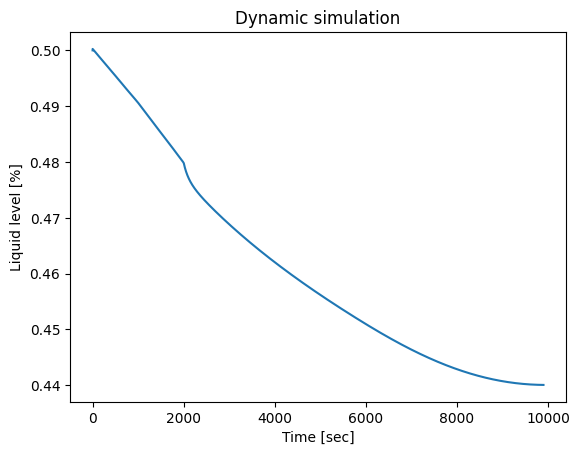

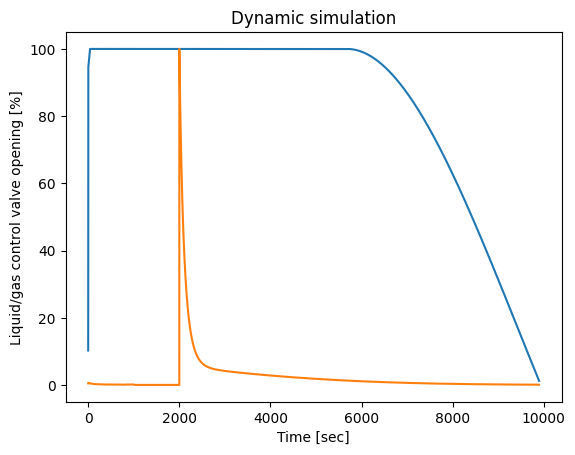

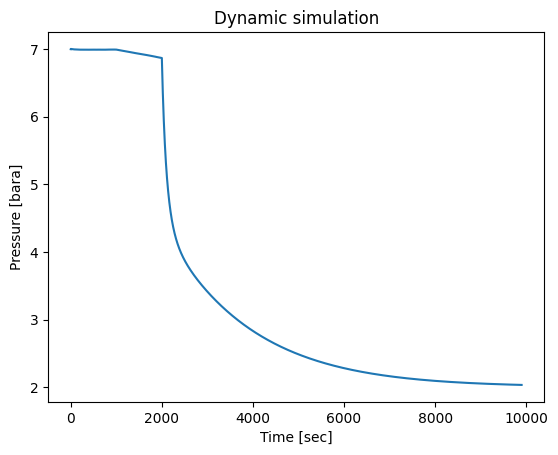

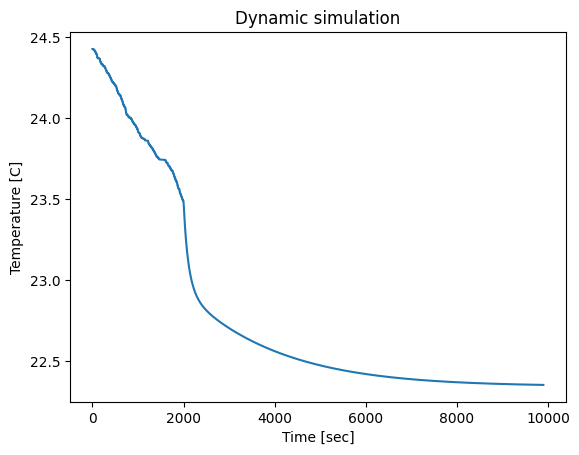

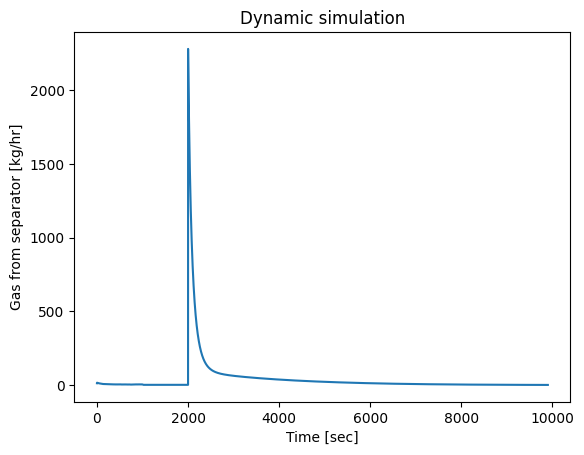

In [76]:
import neqsim
from neqsim import jNeqSim

import matplotlib.pyplot as plt

fluid1 = jNeqSim.thermo.system.SystemSrkEos((273.15 + 25.0), 10.00)
fluid1.addComponent("methane", 0.900)
fluid1.addComponent("n-heptane", 1.00)
fluid1.setMixingRule('classic')

fluid2 = jNeqSim.thermo.system.SystemSrkEos((273.15 + 25.0), 10.00);
fluid2.addComponent("methane", 1.1)
fluid2.addComponent("n-heptane", 1.001)
fluid2.setMixingRule(2)

stream1 = jNeqSim.processSimulation.processEquipment.stream.Stream("Stream1", fluid1);
stream1.setCalculateSteadyState(True);
stream1.setFlowRate(100.0, 'kg/hr')

valve1 = jNeqSim.processSimulation.processEquipment.valve.ThrottlingValve("valve_1", stream1);
valve1.setOutletPressure(7.0);
valve1.setPercentValveOpening(50)
valve1.setMinimumValveOpening(0.1)
valve1.setCalculateSteadyState(False)

purgeStream = jNeqSim.processSimulation.processEquipment.stream.Stream("Purge Stream", fluid2);
purgeStream.setFlowRate(1.0, 'kg/hr')

purgeValve = jNeqSim.processSimulation.processEquipment.valve.ThrottlingValve("purgeValve", purgeStream);
purgeValve.setOutletPressure(7.0);
purgeValve.setPercentValveOpening(50.0);
purgeValve.setCalculateSteadyState(False)
purgeValve.setMinimumValveOpening(0.1)

separator1 = jNeqSim.processSimulation.processEquipment.separator.Separator("separator_1");
separator1.addStream(valve1.getOutletStream())
separator1.addStream(purgeValve.getOutletStream())
separator1.setCalculateSteadyState(False)
separator1.setSeparatorLength(10.0)
separator1.setInternalDiameter(2.2)
separator1.setLiquidLevel(0.5)

valve2 = jNeqSim.processSimulation.processEquipment.valve.ThrottlingValve("valve_2", separator1.getLiquidOutStream());
valve2.setOutletPressure(1.0)
valve2.setPercentValveOpening(40)
valve2.setCalculateSteadyState(False)
valve2.setMinimumValveOpening(0.1)
valve2.setCv(23.9)

valve3 =  jNeqSim.processSimulation.processEquipment.valve.ThrottlingValve("valve_3", separator1.getGasOutStream());
valve3.setOutletPressure(1.0)
valve3.setPercentValveOpening(50)
valve3.setCalculateSteadyState(False)
valve3.setMinimumValveOpening(0.1)
valve3.setCv(12.9)

separatorLevelTransmitter = jNeqSim.processSimulation.measurementDevice.LevelTransmitter(separator1);
separatorLevelTransmitter.setName("separatorLevelTransmitter1");
separatorLevelTransmitter.setMaximumValue(0.8);
separatorLevelTransmitter.setMinimumValue(0.2);

separatorLevelController = jNeqSim.processSimulation.controllerDevice.ControllerDeviceBaseClass()
separatorLevelController.setReverseActing(False)
separatorLevelController.setTransmitter(separatorLevelTransmitter)
separatorLevelController.setControllerSetPoint(0.45)
separatorLevelController.setControllerParameters(10, 500.0, 0.0)

separatorPressureTransmitter = jNeqSim.processSimulation.measurementDevice.PressureTransmitter(separator1.getGasOutStream());
separatorPressureTransmitter.setUnit("bar")
separatorPressureTransmitter.setMaximumValue(10.0)
separatorPressureTransmitter.setMinimumValue(0.0)

separatorPressureController = jNeqSim.processSimulation.controllerDevice.ControllerDeviceBaseClass()
separatorPressureController.setTransmitter(separatorPressureTransmitter)
separatorPressureController.setReverseActing(False)
separatorPressureController.setControllerSetPoint(7.0)
separatorPressureController.setControllerParameters(2, 1000, 1.0)



p = jNeqSim.processSimulation.processSystem.ProcessSystem()
p.add(stream1);
p.add(valve1);
p.add(purgeStream);
p.add(purgeValve);
p.add(separator1);
p.add(valve2);
p.add(valve3);
p.add(separatorLevelTransmitter);
valve2.setController(separatorLevelController);
p.add(separatorPressureTransmitter);
valve3.setController(separatorPressureController);

p.run();

time = []
pressure = []
temperature = []
level = []
liquidvalveopening = []
gasvalveopening = []
gasflowfromsep = []

p.setTimeStep(1);
for i in range(1000):
  time.append(p.getTime())
  pressure.append(separator1.getFluid().getPressure('bara'))
  temperature.append(separator1.getFluid().getTemperature('C'))
  level.append(separatorLevelTransmitter.getMeasuredValue())
  liquidvalveopening.append(valve2.getPercentValveOpening())
  gasvalveopening.append(valve3.getPercentValveOpening())
  gasflowfromsep.append(separator1.getGasOutStream().getFlowRate('kg/hr'))
  p.runTransient()

#Close inlet valve
valve1.setPercentValveOpening(0.1)
purgeValve.setPercentValveOpening(0.1)

for i in range(1000):
  time.append(p.getTime())
  pressure.append(separator1.getFluid().getPressure('bara'))
  temperature.append(separator1.getFluid().getTemperature('C'))
  level.append(separatorLevelTransmitter.getMeasuredValue())
  liquidvalveopening.append(valve2.getPercentValveOpening())
  gasvalveopening.append(valve3.getPercentValveOpening())
  gasflowfromsep.append(separator1.getGasOutStream().getFlowRate('kg/hr'))
  p.runTransient()


separatorPressureController.setControllerSetPoint(2.0)

for i in range(7900):
  time.append(p.getTime())
  pressure.append(separator1.getFluid().getPressure('bara'))
  temperature.append(separator1.getFluid().getTemperature('C'))
  level.append(separatorLevelTransmitter.getMeasuredValue())
  liquidvalveopening.append(valve2.getPercentValveOpening())
  gasvalveopening.append(valve3.getPercentValveOpening())
  gasflowfromsep.append(separator1.getGasOutStream().getFlowRate('kg/hr'))
  p.runTransient()


#plt.plot(time, pressure)
plt.plot(time, level)
plt.title("Dynamic simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Liquid level [%]")
plt.show()

plt.plot(time, liquidvalveopening)
plt.plot(time, gasvalveopening)
plt.title("Dynamic simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Liquid/gas control valve opening [%]")
plt.show()

plt.plot(time, pressure)
plt.title("Dynamic simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Pressure [bara]")
plt.show()

plt.plot(time, temperature)
plt.title("Dynamic simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Temperature [C]")
plt.show()

plt.plot(time, gasflowfromsep)
plt.title("Dynamic simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Gas from separator [kg/hr]")
plt.show()

#Depressuration of a gas tank

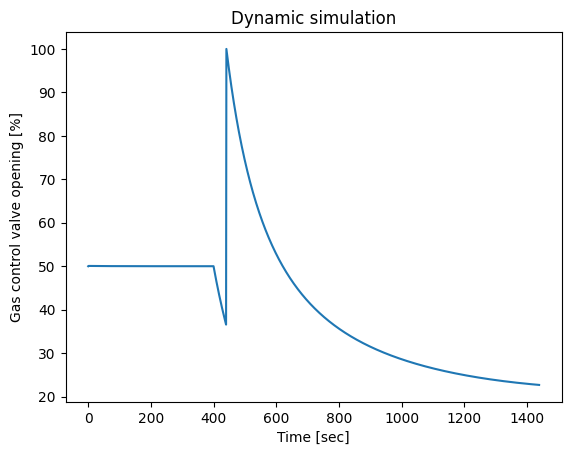

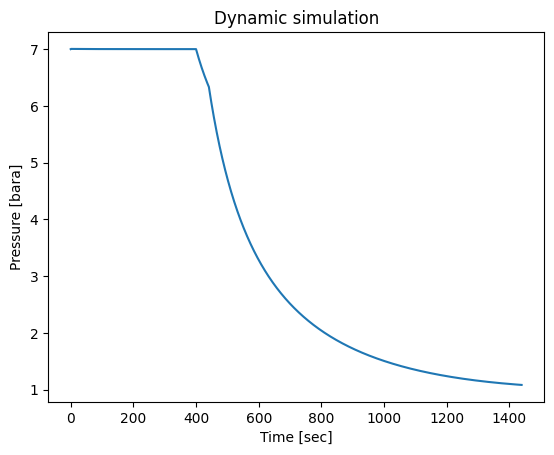

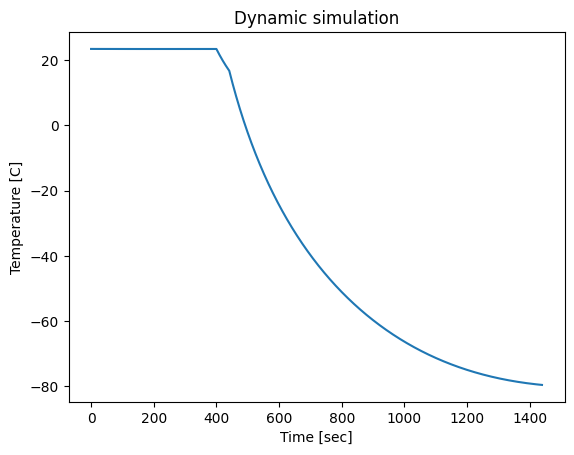

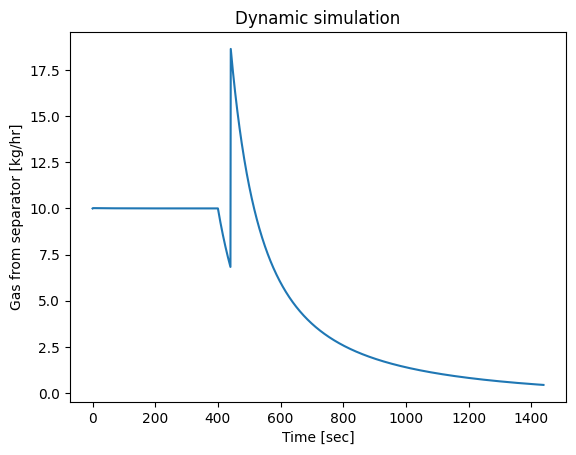

In [79]:
import neqsim
from neqsim import jNeqSim

import matplotlib.pyplot as plt

fluid1 = jNeqSim.thermo.system.SystemSrkEos((273.15 + 25.0), 10.00)
fluid1.addComponent("methane", 0.900)
fluid1.addComponent("ethane", 0.100)
fluid1.setMixingRule('classic')

stream1 = jNeqSim.processSimulation.processEquipment.stream.Stream("Stream1", fluid1);
stream1.setCalculateSteadyState(True);
stream1.setFlowRate(10.0, 'kg/hr')

valve1 = jNeqSim.processSimulation.processEquipment.valve.ThrottlingValve("valve_1", stream1);
valve1.setOutletPressure(7.0);
valve1.setPercentValveOpening(50)
valve1.setMinimumValveOpening(0.1)
valve1.setCalculateSteadyState(False)

separator1 = jNeqSim.processSimulation.processEquipment.separator.Separator("separator_1");
separator1.addStream(valve1.getOutletStream())
separator1.setCalculateSteadyState(False)
separator1.setSeparatorLength(2.0)
separator1.setInternalDiameter(0.4)
separator1.setLiquidLevel(0.0)

valve3 =  jNeqSim.processSimulation.processEquipment.valve.ThrottlingValve("valve_3", separator1.getGasOutStream());
valve3.setOutletPressure(1.0)
valve3.setPercentValveOpening(50)
valve3.setCalculateSteadyState(False)
valve3.setMinimumValveOpening(0.1)
#valve2.setCv(5.9)

separatorPressureTransmitter = jNeqSim.processSimulation.measurementDevice.PressureTransmitter(separator1.getGasOutStream());
separatorPressureTransmitter.setUnit("bar")
separatorPressureTransmitter.setMaximumValue(10.0)
separatorPressureTransmitter.setMinimumValue(0.0)

separatorPressureController = jNeqSim.processSimulation.controllerDevice.ControllerDeviceBaseClass()
separatorPressureController.setTransmitter(separatorPressureTransmitter)
separatorPressureController.setReverseActing(False)
separatorPressureController.setControllerSetPoint(7.0)
separatorPressureController.setControllerParameters(1, 400.0, 1.0)



p = jNeqSim.processSimulation.processSystem.ProcessSystem()
p.add(stream1);
p.add(valve1);
p.add(separator1);
p.add(valve3);
p.add(separatorPressureTransmitter);
valve3.setController(separatorPressureController);

p.run();

time = []
pressure = []
temperature = []
gasvalveopening = []
gasflowfromsep = []

p.setTimeStep(1);
for i in range(400):
  time.append(p.getTime())
  pressure.append(separator1.getFluid().getPressure('bara'))
  temperature.append(separator1.getFluid().getTemperature('C'))
  gasvalveopening.append(valve3.getPercentValveOpening())
  gasflowfromsep.append(separator1.getGasOutStream().getFlowRate('kg/hr'))
  p.runTransient()

#Close inlet valve
valve1.setPercentValveOpening(0.1)

for i in range(40):
  time.append(p.getTime())
  pressure.append(separator1.getFluid().getPressure('bara'))
  temperature.append(separator1.getFluid().getTemperature('C'))
  gasvalveopening.append(valve3.getPercentValveOpening())
  gasflowfromsep.append(separator1.getGasOutStream().getFlowRate('kg/hr'))
  p.runTransient()

separatorPressureController.setControllerSetPoint(1.01325)

for i in range(1000):
  time.append(p.getTime())
  pressure.append(separator1.getFluid().getPressure('bara'))
  temperature.append(separator1.getFluid().getTemperature('C'))
  gasvalveopening.append(valve3.getPercentValveOpening())
  gasflowfromsep.append(separator1.getGasOutStream().getFlowRate('kg/hr'))
  p.runTransient()


plt.plot(time, gasvalveopening)
plt.title("Dynamic simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Gas control valve opening [%]")
plt.show()

plt.plot(time, pressure)
plt.title("Dynamic simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Pressure [bara]")
plt.show()

plt.plot(time, temperature)
plt.title("Dynamic simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Temperature [C]")
plt.show()

plt.plot(time, gasflowfromsep)
plt.title("Dynamic simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Gas from separator [kg/hr]")
plt.show()